# Logistic Regression Baseline for Wildfire Prediction

This notebook demonstrates how to build a **logistic regression** model as a baseline classifier for predicting wildfire occurrences using weather and environmental variables. Logistic regression is a simple yet powerful linear model that estimates the probability of a binary outcome—in this case, whether a wildfire occurs (`fire_occurred = 1`) or not (`fire_occurred = 0`).

Because the wildfire dataset is often highly imbalanced, with far fewer wildfire events than non‑events, it’s important to account for this imbalance when training the model. In the following sections we load the data, perform basic cleaning, engineer features, split the data into training and testing sets, scale the features, train a logistic regression classifier with balanced class weights, and evaluate its performance.


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Display settings
pd.set_option('display.max_columns', None)


2025-08-05 12:21:59.357015: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# TODO: Update the file path to point to your data file
data_path = './matched_data_20_miles.csv'

# Load the matched data
final_matched_data = pd.read_csv(data_path)

# Identify quality control (QC) columns and remove rows with unreliable flags
qc_columns = ['qc.1','qc.2','qc.3','qc.4','qc.5','qc.6','qc.7','qc.8','qc.9','qc.10','qc.11','qc.12','qc.13']
excluded_flags = {'M','I','S'}  # Missing, Invalid, or suspect readings

qc_data = final_matched_data[qc_columns].astype(str)

def contains_excluded_flag(series, excluded_flags):
    return series.apply(lambda val: any(flag in val for flag in excluded_flags))

# Create a mask for rows without excluded QC flags
column_masks = qc_data.apply(lambda col: ~contains_excluded_flag(col, excluded_flags))
mask = column_masks.all(axis=1)

# Filter out poor‑quality rows
cleaned_data = final_matched_data[mask].copy()
print(f'Removed {(~mask).sum()} rows due to QC flags.')


Removed 13913 rows due to QC flags.


In [3]:
# List the base feature columns
general_features = [
    'ETo (mm)', 'Precip (mm)', 'Sol Rad (W/sq.m)', 'Avg Vap Pres (kPa)',
    'Max Air Temp (C)', 'Min Air Temp (C)', 'Avg Air Temp (C)',
    'Max Rel Hum (%)', 'Min Rel Hum (%)', 'Avg Rel Hum (%)',
    'Dew Point (C)', 'Avg Wind Speed (m/s)', 'Wind Run (km)', 'Avg Soil Temp (C)'
]

# Compute a 7‑day trailing average for each feature within each weather station
for col in general_features:
    cleaned_data[f'{col}_7d_avg'] = (
        cleaned_data.groupby('StationNbr')[col]
        .transform(lambda x: x.rolling(7, min_periods=1).mean())
    )

# Select the trailing average features and the target label
all_trailing_features = [f'{col}_7d_avg' for col in general_features]
X = cleaned_data[all_trailing_features].dropna()
y = cleaned_data.loc[X.index, 'fire_occurred']

print(f'Feature matrix shape: {X.shape}')


Feature matrix shape: (183666, 14)


In [4]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features using z‑score scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression with balanced class weights
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test_scaled)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.60      0.74     36298
           1       0.02      0.73      0.04       436

    accuracy                           0.60     36734
   macro avg       0.51      0.66      0.39     36734
weighted avg       0.98      0.60      0.74     36734



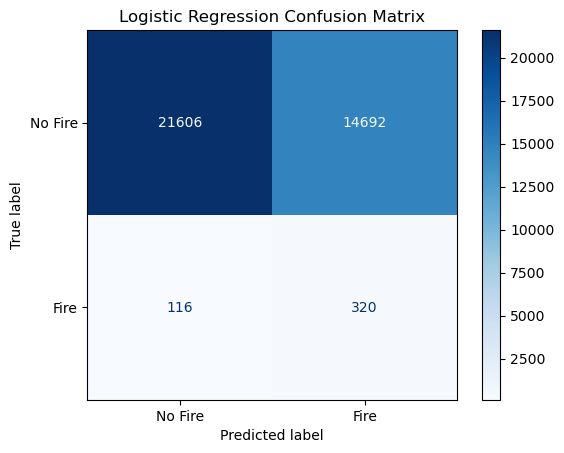

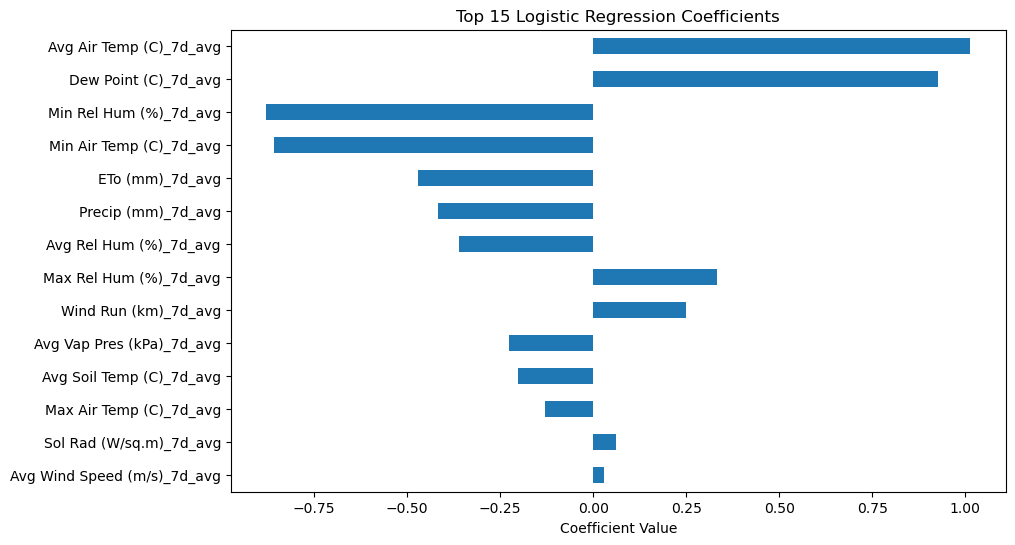

In [5]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fire','Fire'])
disp.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Optional: Visualize feature importance via model coefficients
coefficients = pd.Series(log_reg.coef_[0], index=X.columns)
coefficients.sort_values(key=lambda s: abs(s), ascending=False, inplace=True)
plt.figure(figsize=(10,6))
coefficients.head(15).plot(kind='barh')
plt.title('Top 15 Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()
plt.show()


## Conclusion

This notebook provided a straightforward logistic regression baseline for wildfire prediction. We cleaned the raw matched dataset by removing rows with unreliable quality‑control flags, engineered 7‑day trailing averages for key weather features, and trained a logistic regression classifier with balanced class weights to handle the imbalanced target distribution.

    •	Logistic Regression:
Accuracy = 60%, Precision = 2 % for the wildfire class, Recall = 74%

(poor accuracy and precision, better recall)


Compare these results to other models such as Random Forests, gradient boosting (e.g., XGBoost), or deep neural networks. LR offers an interpretable baseline.